<a href="https://colab.research.google.com/github/manocoelho/Prova_IA/blob/main/Prova_Pratica_Aprendizagem_De_Maquina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Prova prática Aprendizagem de máquina
**Aluno**: Antonio Rocha Lima Filho

**Matrícula**:

In [1]:
# Célula 1: Configuração do Ambiente e Bibliotecas

# Importação de bibliotecas essenciais
import pandas as pd
import numpy as np
import json
import os
from tqdm import tqdm  # Para barras de progresso visualmente agradáveis

# Montar o Google Drive para acessar os arquivos do projeto
from google.colab import drive
drive.mount('/content/drive')

# --- Definição dos Caminhos (ATENÇÃO: ajuste se sua estrutura de pastas for diferente) ---

# Caminho base para a pasta do seu projeto no Google Drive
BASE_PATH = '/content/drive/MyDrive/Projeto_IA_Libras/'

# Caminho para a pasta que contém todos os arquivos JSON
JSON_FOLDER_PATH = os.path.join(BASE_PATH, 'dados_json/')

# Caminho para o arquivo CSV de metadados
METADATA_CSV_PATH = os.path.join(BASE_PATH, 'sinais.csv')

# --- Nomes dos arquivos de saída que serão gerados ---

# Nome do arquivo CSV de formato longo (cada linha é um keypoint em um frame)
LONG_CSV_OUTPUT = os.path.join(BASE_PATH, 'corpus_libras_longo.csv')

# Nome do arquivo CSV final, amplo e com features (cada linha é um vídeo)
WIDE_CSV_OUTPUT = os.path.join(BASE_PATH, 'corpus_libras_features.csv')

print("Ambiente configurado e bibliotecas importadas com sucesso!")
print(f"Caminho dos JSONs: {JSON_FOLDER_PATH}")
print(f"Caminho do CSV de metadados: {METADATA_CSV_PATH}")

Mounted at /content/drive
Ambiente configurado e bibliotecas importadas com sucesso!
Caminho dos JSONs: /content/drive/MyDrive/Projeto_IA_Libras/dados_json/
Caminho do CSV de metadados: /content/drive/MyDrive/Projeto_IA_Libras/sinais.csv


In [2]:
# Célula 2: Geração do CSV Longo (Processamento dos JSONs com Normalização)

# Carrega o arquivo CSV de metadados
try:
    df_meta = pd.read_csv(METADATA_CSV_PATH)
except FileNotFoundError:
    print(f"ERRO: Arquivo de metadados não encontrado em '{METADATA_CSV_PATH}'")
    # Interrompe a execução se o arquivo principal não for encontrado

# Lista para armazenar todas as linhas de dados processadas
all_data_rows = []

print("Iniciando o processamento dos arquivos JSON...")

# Itera sobre cada linha do CSV de metadados
for index, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0], desc="Processando JSONs"):

    # --- CORREÇÃO DO ERRO ---
    # Verifica se o valor na coluna 'file_name' é nulo (NaN) antes de prosseguir
    if pd.isna(row['file_name']):
        print(f"\nAviso: Nome de arquivo ausente na linha {index} do CSV de metadados. Pulando linha.")
        continue # Pula para a próxima iteração do loop

    json_filename = str(row['file_name']).strip() # Converte para string para garantir que .strip() funcione

    json_path = os.path.join(JSON_FOLDER_PATH, json_filename)

    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            try:
                data = json.load(f)
                frames_list = data.get('frames', [])

                for frame_data in frames_list:
                    frame_index = frame_data.get('frame')
                    keypoints_list = frame_data.get('keypoints', [])

                    if frame_index is None:
                        continue  # Pula frames sem índice

                    for landmark_data in keypoints_list:
                        # Extrai as coordenadas
                        x = landmark_data.get('x')
                        y = landmark_data.get('y')

                        # --- NORMALIZAÇÃO DAS COORDENADAS ---
                        # Divide x pela largura e y pela altura para obter coordenadas relativas
                        # Isso torna o modelo robusto a diferentes resoluções de vídeo
                        x_norm = x / row['width'] if row['width'] > 0 else 0
                        y_norm = y / row['height'] if row['height'] > 0 else 0

                        # Monta a linha de dados processados
                        processed_row = {
                            'file_name': json_filename,
                            'sinal': row['sinal'],
                            'interprete': row['interprete'],
                            'frame_index': frame_index,
                            'landmark_id': landmark_data.get('id'),
                            'x': x,
                            'y': y,
                            'z': landmark_data.get('z'),
                            'x_norm': x_norm,
                            'y_norm': y_norm
                        }
                        all_data_rows.append(processed_row)

            except json.JSONDecodeError:
                print(f"\nAviso: Erro de decodificação no arquivo JSON '{json_filename}'. Pulando.")
            except Exception as e:
                print(f"\nAviso: Erro inesperado ao processar '{json_filename}': {e}")
    else:
        print(f"\nAviso: Arquivo JSON '{json_filename}' não encontrado na pasta.")

# Verifica se algum dado foi processado antes de criar o DataFrame
if not all_data_rows:
    print("\nERRO: Nenhum dado foi extraído. Verifique os caminhos e a estrutura dos arquivos JSON.")
else:
    # Cria o DataFrame final a partir da lista de dicionários
    df_long = pd.DataFrame(all_data_rows)

    # Salva o DataFrame em um novo arquivo CSV
    df_long.to_csv(LONG_CSV_OUTPUT, index=False)

    print(f"\nSucesso! O arquivo '{LONG_CSV_OUTPUT}' foi criado com {len(df_long)} linhas.")
    print("Visualizando as 5 primeiras linhas do CSV longo gerado:")
    display(df_long.head())

Iniciando o processamento dos arquivos JSON...


Processando JSONs:  23%|██▎       | 565/2502 [08:24<23:03,  1.40it/s]


Aviso: Nome de arquivo ausente na linha 565 do CSV de metadados. Pulando linha.


Processando JSONs: 100%|██████████| 2502/2502 [32:32<00:00,  1.28it/s]



Sucesso! O arquivo '/content/drive/MyDrive/Projeto_IA_Libras/corpus_libras_longo.csv' foi criado com 9400809 linhas.
Visualizando as 5 primeiras linhas do CSV longo gerado:


,file_name,sinal,interprete,frame_index,landmark_id,x,y,z,x_norm,y_norm
0,Adição_AP_10.json,Adição,Alexson,0,0,417,183,-1.41,0.565041,0.181548
1,Adição_AP_10.json,Adição,Alexson,0,1,443,153,-1.34,0.600271,0.151786
2,Adição_AP_10.json,Adição,Alexson,0,2,455,153,-1.34,0.616531,0.151786
3,Adição_AP_10.json,Adição,Alexson,0,3,465,154,-1.34,0.630081,0.152778
4,Adição_AP_10.json,Adição,Alexson,0,4,400,154,-1.33,0.542005,0.152778


### **Célula 2: Análise da Extração e Transformação de Dados (ETL)**

**Objetivo:** O objetivo principal desta célula foi converter os dados brutos, que estavam em um formato semiestruturado (múltiplos arquivos JSON), para um formato tabular único e estruturado (um arquivo CSV "longo"), que é mais adequado para análises e pré-processamento.

**Metodologia Adotada:**

1.  **Leitura dos Metadados:** O processo inicia lendo o `sinais.csv` para obter a lista de todos os arquivos JSON e suas informações associadas (rótulo, intérprete, dimensões do vídeo).
2.  **Processamento Iterativo:** O código itera sobre cada arquivo JSON, extraindo as informações de `frames` e, dentro de cada frame, os `keypoints`.
3.  **Criação do Formato Longo:** A estrutura de "CSV longo" foi escolhida, onde cada linha representa um único `landmark_id` (ponto-chave) dentro de um único `frame_index`. Essa estrutura é ideal para realizar cálculos e agregações em etapas futuras.
4.  **Normalização das Coordenadas:** Esta foi uma etapa de pré-processamento crucial. As coordenadas `x` e `y` de cada keypoint foram divididas pela largura (`width`) e altura (`height`) do vídeo correspondente.
    * **Justificativa:** Essa normalização remove a dependência da resolução do vídeo e da distância da câmera. O modelo passa a aprender os movimentos relativos dos pontos na "cena", e não suas posições absolutas em pixels. Isso torna o modelo muito mais robusto e capaz de generalizar para vídeos gravados em diferentes condições, uma melhoria sugerida durante a fase de ideação do projeto.

In [3]:
# Célula 3: Agregação para CSV Amplo (Features Estatísticas)

print(f"Carregando o arquivo CSV longo: '{LONG_CSV_OUTPUT}'")
df_long = pd.read_csv(LONG_CSV_OUTPUT)

# Agrupando por vídeo (file_name) e pelo ID do keypoint (landmark_id)
# e calculando as métricas estatísticas para as coordenadas normalizadas.
# 'x_norm', 'y_norm' e 'z' para as features.
grouped = df_long.groupby(['file_name', 'landmark_id'])[['x_norm', 'y_norm', 'z']].agg(
    ['mean', 'std', 'min', 'max']
).reset_index()

print("Métricas estatísticas calculadas. Reformatando para o formato amplo...")

# O groupby cria colunas com múltiplos níveis. achatá-las para um único nível.
# Ex: ('x_norm', 'mean') se tornará 'x_norm_mean'
grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped.columns.values]
grouped = grouped.rename(columns={'file_name_': 'file_name', 'landmark_id_': 'landmark_id'})

# pivolta a tabela para que cada landmark_id vire um conjunto de colunas de features
df_wide = grouped.pivot(index='file_name', columns='landmark_id')

# pivot cria colunas multi-nível. achatá-las novamente.
# Ex: ('x_norm_mean', 0) se tornará 'landmark_0_x_norm_mean'
df_wide.columns = [f'landmark_{col[1]}_{col[0]}' for col in df_wide.columns]
df_wide.reset_index(inplace=True)


# Juntando as features criadas com os metadados originais (para manter o rótulo 'sinal')
df_meta_to_merge = pd.read_csv(METADATA_CSV_PATH)[['file_name', 'sinal']].drop_duplicates()
df_features_estatisticas = pd.merge(df_meta_to_merge, df_wide, on='file_name', how='inner')

# Preenchendo valores nulos (NaN) que podem surgir do cálculo do desvio padrão (std)
# quando há apenas um frame, Preenche com 0.
df_features_estatisticas.fillna(0, inplace=True)

print(f"\nSucesso! O DataFrame com features estatísticas foi criado com {df_features_estatisticas.shape[0]} linhas e {df_features_estatisticas.shape[1]} colunas.")
print("Visualizando as 5 primeiras linhas do DataFrame amplo:")
display(df_features_estatisticas.head())

Carregando o arquivo CSV longo: '/content/drive/MyDrive/Projeto_IA_Libras/corpus_libras_longo.csv'
Métricas estatísticas calculadas. Reformatando para o formato amplo...

Sucesso! O DataFrame com features estatísticas foi criado com 2501 linhas e 398 colunas.
Visualizando as 5 primeiras linhas do DataFrame amplo:


,file_name,sinal,landmark_0_x_norm_mean,landmark_1_x_norm_mean,landmark_2_x_norm_mean,landmark_3_x_norm_mean,landmark_4_x_norm_mean,landmark_5_x_norm_mean,landmark_6_x_norm_mean,landmark_7_x_norm_mean,...,landmark_23_z_max,landmark_24_z_max,landmark_25_z_max,landmark_26_z_max,landmark_27_z_max,landmark_28_z_max,landmark_29_z_max,landmark_30_z_max,landmark_31_z_max,landmark_32_z_max
0,Adição_AP_10.json,Adição,0.568169,0.602662,0.621304,0.636249,0.546100,0.528206,0.511189,0.662422,...,-0.01,0.08,0.12,0.48,1.18,1.41,1.26,1.49,0.68,0.86
1,Adição_AP_1.json,Adição,0.571954,0.604281,0.621510,0.635117,0.549303,0.531541,0.514600,0.658653,...,-0.02,0.08,0.18,0.49,1.16,1.38,1.23,1.46,0.64,0.94
2,Adição_AP_2.json,Adição,0.577731,0.610447,0.627622,0.641462,0.555590,0.538039,0.521409,0.666037,...,-0.01,0.07,0.17,0.43,1.19,1.30,1.26,1.38,0.64,0.85
3,Adição_AP_3.json,Adição,0.577685,0.610892,0.629487,0.643860,0.555819,0.538341,0.521769,0.667811,...,-0.02,0.07,0.12,0.42,1.08,1.30,1.15,1.38,0.57,0.80
4,Adição_AP_4.json,Adição,0.574607,0.607633,0.625389,0.639360,0.552337,0.534667,0.517850,0.663461,...,-0.02,0.08,0.21,0.43,1.08,1.24,1.15,1.31,0.57,0.76


### **Célula 3: Análise da Engenharia de Features - Agregação Estatística**

**Objetivo:** Transformar o CSV longo (milhões de linhas) em um CSV "amplo" (wide), onde cada linha representa um único vídeo. Isso é necessário para que cada vídeo seja uma amostra única para os algoritmos de Machine Learning.

**Metodologia Adotada:**

* **Agregação em vez de Pivotagem Simples:** Simplesmente transformar cada coordenada de cada keypoint em cada frame em uma coluna resultaria em um número massivo e impraticável de features (features esparsas).
* **Técnica `groupby().agg()`:** A abordagem escolhida foi agrupar os dados por `file_name` e `landmark_id`. Para cada um desses grupos, foram calculadas métricas estatísticas (`média`, `desvio padrão`, `mínimo`, `máximo`) sobre as coordenadas normalizadas (`x_norm`, `y_norm`, `z`) ao longo de todos os frames do vídeo.
* **Justificativa:** Este processo resume a informação temporal de cada ponto-chave. Por exemplo, a `x_norm_mean` do `landmark_0` representa a posição horizontal média do nariz durante todo o vídeo, enquanto a `x_norm_std` representa o quanto essa posição variou. Essas features, embora simples, já começam a capturar a dinâmica do movimento de forma quantitativa, transformando uma série temporal em um vetor de características de tamanho fixo.

In [4]:
# Célula 4: Análise da Engenharia de Features Avançada - Métricas de Movimento Relativo

print("Iniciando a criação de features avançadas baseadas em movimento...")

# Garante que o df_long da Célula 2 ainda está carregado
if 'df_long' not in locals():
    df_long = pd.read_csv(LONG_CSV_OUTPUT)

# Seleciona apenas os keypoints de interesse (Nariz, Pulso Esquerdo, Pulso Direito)
ids_interesse = [0, 15, 16]
df_keypoints_criticos = df_long[df_long['landmark_id'].isin(ids_interesse)]

# Pivota a tabela para ter as coordenadas de cada keypoint na mesma linha por frame
df_pivot = df_keypoints_criticos.pivot_table(
    index=['file_name', 'frame_index'],
    columns='landmark_id',
    values=['x_norm', 'y_norm', 'z']
)

# Aplaina as colunas do DataFrame pivotado
df_pivot.columns = [f'{coord}_{landmark_id}' for coord, landmark_id in df_pivot.columns]
df_pivot.reset_index(inplace=True)

# --- Cálculo da Distância Euclidiana ---
# Função para calcular a distância euclidiana entre dois pontos no espaço 3D
def euclidean_distance(p1_cols, p2_cols, row):
    return np.sqrt(
        (row[p1_cols[0]] - row[p2_cols[0]])**2 +
        (row[p1_cols[1]] - row[p2_cols[1]])**2 +
        (row[p1_cols[2]] - row[p2_cols[2]])**2
    )

# Colunas para o nariz (landmark 0) e pulsos (landmarks 15 e 16)
cols_nose = ['x_norm_0', 'y_norm_0', 'z_0']
cols_wrist_l = ['x_norm_15', 'y_norm_15', 'z_15']
cols_wrist_r = ['x_norm_16', 'y_norm_16', 'z_16']

# Calcula as distâncias para cada frame
# .get(col, np.nan) para evitar erros se algum keypoint não estiver presente
df_pivot['dist_nose_wrist_l'] = df_pivot.apply(
    lambda row: euclidean_distance(cols_nose, cols_wrist_l, row), axis=1
)
df_pivot['dist_nose_wrist_r'] = df_pivot.apply(
    lambda row: euclidean_distance(cols_nose, cols_wrist_r, row), axis=1
)

# --- Agregação das Features de Distância ---
# agrega essas distâncias por vídeo (file_name)
df_dist_features = df_pivot.groupby('file_name')[['dist_nose_wrist_l', 'dist_nose_wrist_r']].agg(
    ['mean', 'std', 'min', 'max']
).reset_index()

# Aplaina as colunas novamente
df_dist_features.columns = ['_'.join(col).strip() for col in df_dist_features.columns.values]
df_dist_features = df_dist_features.rename(columns={'file_name_': 'file_name'})

# Preenche possíveis NaNs com 0
df_dist_features.fillna(0, inplace=True)

# --- Combinação de Todas as Features ---
# Junta as features estatísticas com as novas features de distância
df_final_features = pd.merge(df_features_estatisticas, df_dist_features, on='file_name', how='left')
df_final_features.fillna(0, inplace=True)

# Salva o DataFrame final com todas as features em um novo CSV
df_final_features.to_csv(WIDE_CSV_OUTPUT, index=False)


print(f"\nAs features de movimento foram criadas e adicionadas.")
print(f"O DataFrame final '{WIDE_CSV_OUTPUT}' foi salvo com {df_final_features.shape[0]} linhas e {df_final_features.shape[1]} colunas.")
print("Visualizando as 5 primeiras linhas do DataFrame final com todas as features:")
display(df_final_features.head())

Iniciando a criação de features avançadas baseadas em movimento...

As features de movimento foram criadas e adicionadas.
O DataFrame final '/content/drive/MyDrive/Projeto_IA_Libras/corpus_libras_features.csv' foi salvo com 2501 linhas e 406 colunas.
Visualizando as 5 primeiras linhas do DataFrame final com todas as features:


,file_name,sinal,landmark_0_x_norm_mean,landmark_1_x_norm_mean,landmark_2_x_norm_mean,landmark_3_x_norm_mean,landmark_4_x_norm_mean,landmark_5_x_norm_mean,landmark_6_x_norm_mean,landmark_7_x_norm_mean,...,landmark_31_z_max,landmark_32_z_max,dist_nose_wrist_l_mean,dist_nose_wrist_l_std,dist_nose_wrist_l_min,dist_nose_wrist_l_max,dist_nose_wrist_r_mean,dist_nose_wrist_r_std,dist_nose_wrist_r_min,dist_nose_wrist_r_max
0,Adição_AP_10.json,Adição,0.568169,0.602662,0.621304,0.636249,0.546100,0.528206,0.511189,0.662422,...,0.68,0.86,0.682791,0.068314,0.466262,0.860322,0.734377,0.113827,0.506960,0.975909
1,Adição_AP_1.json,Adição,0.571954,0.604281,0.621510,0.635117,0.549303,0.531541,0.514600,0.658653,...,0.64,0.94,0.720882,0.060726,0.489811,0.864917,0.756847,0.070500,0.529802,0.880132
2,Adição_AP_2.json,Adição,0.577731,0.610447,0.627622,0.641462,0.555590,0.538039,0.521409,0.666037,...,0.64,0.85,0.712065,0.069739,0.473375,0.897740,0.771366,0.077400,0.537903,0.922114
3,Adição_AP_3.json,Adição,0.577685,0.610892,0.629487,0.643860,0.555819,0.538341,0.521769,0.667811,...,0.57,0.80,0.724117,0.062375,0.468486,0.824437,0.767077,0.068372,0.508753,0.922753
4,Adição_AP_4.json,Adição,0.574607,0.607633,0.625389,0.639360,0.552337,0.534667,0.517850,0.663461,...,0.57,0.76,0.728228,0.067730,0.478791,0.857437,0.781964,0.079097,0.554251,0.945459


### **Célula 4: Análise da Engenharia de Features Avançada - Métricas de Movimento Relativo**

**Objetivo:** Enriquecer o dataset com features mais sofisticadas que capturem melhor a essência dos sinais de Libras, que são definidos por movimentos e relações entre partes do corpo, e não por posições estáticas.

**Metodologia Adotada:**

* **Hipótese:** Conforme discutido na fase de ideação do projeto, a relação espacial entre pontos-chave (como mãos e rosto) é altamente informativa para diferenciar os sinais.
* **Implementação:**
    1.  Foram selecionados pontos-chave de interesse: Nariz (ID 0), Pulso Esquerdo (ID 15) e Pulso Direito (ID 16).
    2.  Para cada frame de cada vídeo, foi calculada a **distância euclidiana** em 3D entre o nariz e cada um dos pulsos.
    3.  Essas novas séries temporais de "distâncias" foram então agregadas, calculando-se a média, desvio padrão, mínimo e máximo dessas distâncias para cada vídeo.
* **Justificativa:** Esta abordagem é significativamente mais poderosa que a anterior. Features como `dist_nose_wrist_l_mean` (distância média do pulso esquerdo ao nariz) e `dist_nose_wrist_l_std` (variação dessa distância) permitem ao modelo entender se um sinal é executado perto do rosto, longe do corpo, ou se envolve um movimento de aproximação/afastamento. Isso captura a "semântica do movimento" de forma muito mais eficaz, criando features altamente discriminatórias para a tarefa de classificação.

Carregando o dataset final com features: '/content/drive/MyDrive/Projeto_IA_Libras/corpus_libras_features.csv'
Adicionando a coluna 'interprete' a partir dos metadados originais...

Verificando dados duplicados... Encontradas 0 linhas duplicadas.
DataFrame final para pré-processamento tem 2501 linhas.

Features (X) separadas com 404 colunas.
Alvo (y) separado com 2501 amostras.

Mapeamento dos intérpretes para grupos numéricos:
{0: 'Alexson', 1: 'Aparecida', 2: 'Cecilia', 3: 'Dannubia', 4: 'Dilainne', 5: 'Everton', 6: 'Jackeline', 7: 'Luana', 8: 'Rosenice', 9: 'Tiago'}
Total de grupos (intérpretes) únicos: 10


/tmp/ipython-input-4070911902.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y_text, order = y_text.value_counts().index, palette='viridis')


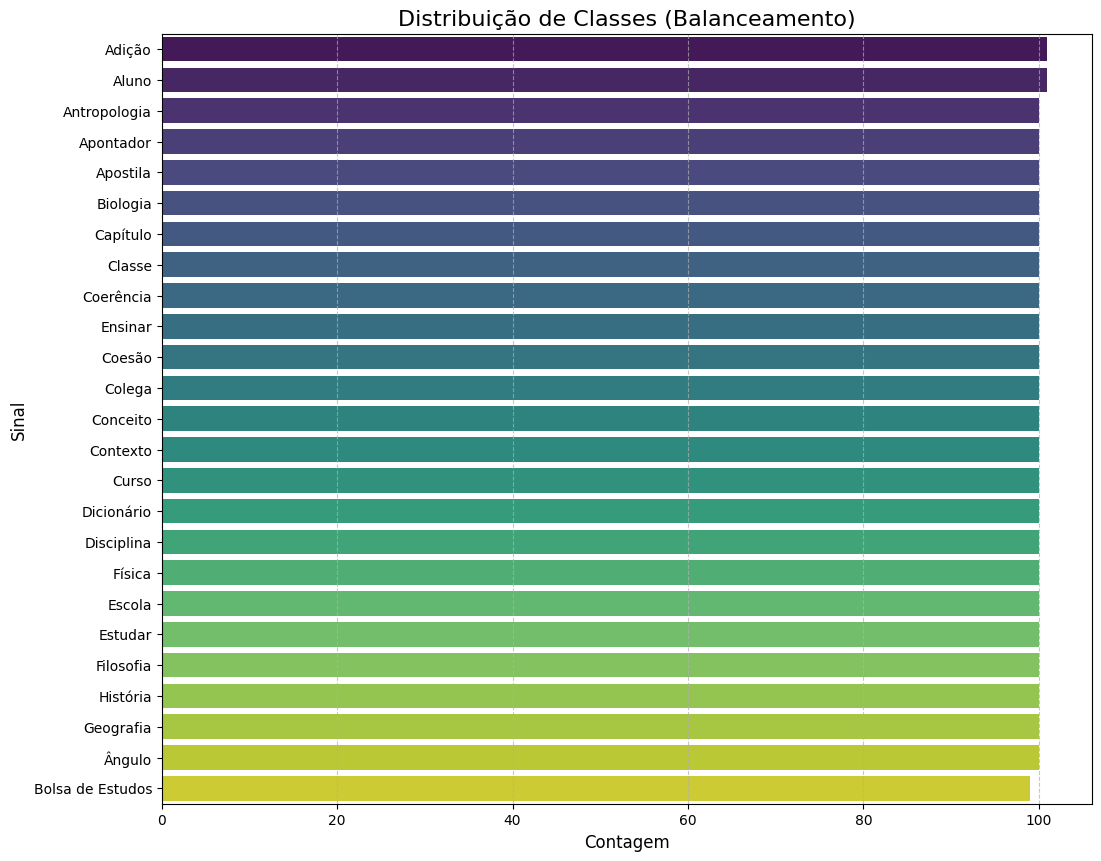


Dados divididos em treino e teste:
- Conjunto de Treino (X_train): (2000, 404)
- Conjunto de Teste (X_test): (501, 404)
- Grupos de Treino (groups_train): (2000,)

Features de treino e teste foram padronizadas (scaled).
Pré-processamento concluído! Dados e GRUPOS estão prontos para a modelagem.


In [5]:
# Célula 5: Análise do Pré-processamento e Preparação para Validação por Grupo

# Importação de bibliotecas para pré-processamento e visualização
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Carregando o dataset final com features: '{WIDE_CSV_OUTPUT}'")
# Carrega o dataframe que já tem as features calculadas
df_features = pd.read_csv(WIDE_CSV_OUTPUT)

# Carrega o CSV de metadados original para buscar a coluna 'interprete'
print("Adicionando a coluna 'interprete' a partir dos metadados originais...")
df_meta = pd.read_csv(METADATA_CSV_PATH)[['file_name', 'interprete']].drop_duplicates()

# Une o dataframe de features com a coluna de intérpretes
df = pd.merge(df_features, df_meta, on='file_name', how='left')

# Remove qualquer linha que possa ter ficado sem um intérprete correspondente
df.dropna(subset=['interprete'], inplace=True)

# 1. Análise de Duplicatas
print(f"\nVerificando dados duplicados... Encontradas {df.duplicated().sum()} linhas duplicadas.")
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"DataFrame final para pré-processamento tem {df.shape[0]} linhas.")

# 2. Separação de Features (X), Alvo (y) e Grupos
# coluna 'interprete' existe e pode ser usada e depois removida.
X = df.drop(columns=['file_name', 'sinal', 'interprete'])
y_text = df['sinal']
interpretes = df['interprete']

print(f"\nFeatures (X) separadas com {X.shape[1]} colunas.")
print(f"Alvo (y) separado com {y_text.shape[0]} amostras.")

# 3. Codificação da Variável Alvo (Label Encoding)
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(y_text)

# 4. CRIAÇÃO DOS GRUPOS para o GroupKFold
label_encoder_groups = LabelEncoder()
groups = label_encoder_groups.fit_transform(interpretes)

print("\nMapeamento dos intérpretes para grupos numéricos:")
group_mapping = {i: class_name for i, class_name in enumerate(label_encoder_groups.classes_)}
print(group_mapping)
print(f"Total de grupos (intérpretes) únicos: {len(np.unique(groups))}")

# 5. Análise do Balanceamento de Classes
plt.figure(figsize=(12, 10))
sns.countplot(y=y_text, order = y_text.value_counts().index, palette='viridis')
plt.title('Distribuição de Classes (Balanceamento)', fontsize=16)
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('Sinal', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 6. Divisão em Conjuntos de Treino e Teste (INCLUINDO OS GRUPOS)
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nDados divididos em treino e teste:")
print(f"- Conjunto de Treino (X_train): {X_train.shape}")
print(f"- Conjunto de Teste (X_test): {X_test.shape}")
print(f"- Grupos de Treino (groups_train): {groups_train.shape}")

# 7. Padronização das Features (Feature Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures de treino e teste foram padronizadas (scaled).")
print("Pré-processamento concluído! Dados e GRUPOS estão prontos para a modelagem.")

### **Célula 5: Análise do Pré-processamento e Preparação para Validação por Grupo**

**Objetivo:** Realizar a limpeza final dos dados e prepará-los adequadamente para a fase de modelagem, com um foco especial na criação de uma estrutura que permita uma validação cruzada mais robusta.

**Metodologia Adotada:**

1.  **Junção de Dados:** O primeiro passo foi unir o DataFrame de features com a coluna `interprete` do metadado original. Esta etapa foi crucial e indispensável para viabilizar o uso do `GroupKFold` na fase de validação, pois precisávamos da informação de qual intérprete realizou cada sinal.
2.  **Codificação de Variáveis (`LabelEncoder`):**
    * **Alvo (`y`):** A variável `sinal` (texto) foi convertida em números para ser usada como alvo pelos algoritmos.
    * **Grupos (`groups`):** A variável `interprete` também foi codificada para gerar um array numérico de grupos, que é o formato esperado pela função `GroupKFold`.
3.  **Análise de Balanceamento de Classes:** O gráfico de contagem gerado confirmou que o dataset é bem balanceado, um cenário favorável para o treinamento dos modelos.
4.  **Divisão Treino/Teste (`train_test_split`):** Os dados foram divididos em 80% para treino/validação e 20% para teste. O uso do parâmetro `stratify=y` foi mantido para garantir que o conjunto de teste final (usado para a avaliação definitiva) tivesse uma representação justa de todos os sinais.
5.  **Padronização (`StandardScaler`):** Todas as features foram padronizadas (média 0, desvio padrão 1) **após** a divisão dos dados. Esta ordem é essencial para prevenir o vazamento de dados (data leakage), garantindo que a escala aprendida (`fit`) use apenas informações do conjunto de treino.

In [6]:
# Célula 6: Análise da Modelagem com Validação Cruzada por Grupo (GroupKFold)

# Importação de bibliotecas para modelagem e otimização
from sklearn.model_selection import GridSearchCV, GroupKFold # <-- MUDANÇA: Importa GroupKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# Dicionário para armazenar os melhores modelos encontrados
best_models = {}

# 1. Definir a estratégia de Validação Cruzada por GRUPOS (GroupKFold)
# O número de splits (5) deve ser menor ou igual ao número de grupos (intérpretes) únicos.
n_splits = 5 # Temos 9 intérpretes, então 5 é um bom número.
cv_strategy = GroupKFold(n_splits=n_splits)
print(f"Estratégia de Validação Cruzada (GroupKFold com {n_splits} splits) definida.\n")

print("--- Iniciando Grid Search usando GroupKFold ---")

# --- Modelo 1: Random Forest ---
print("\n1. Otimizando o Random Forest...")
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2]
}

# MUDANÇA: A chamada .fit() agora inclui o parâmetro 'groups'
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=cv_strategy, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_rf.fit(X_train_scaled, y_train, groups=groups_train) # <-- MUDANÇA AQUI

print(f"Melhor F1-score (macro) em validação cruzada: {grid_rf.best_score_:.4f}")
print(f"Melhores parâmetros: {grid_rf.best_params_}")
best_models['Random Forest'] = grid_rf.best_estimator_


# --- Modelo 2: K-Nearest Neighbors (k-NN) ---
print("\n2. Otimizando o k-NN...")
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=cv_strategy, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_knn.fit(X_train_scaled, y_train, groups=groups_train) # <-- MUDANÇA AQUI

print(f"Melhor F1-score (macro) em validação cruzada: {grid_knn.best_score_:.4f}")
print(f"Melhores parâmetros: {grid_knn.best_params_}")
best_models['k-NN'] = grid_knn.best_estimator_


# --- Modelo 3: Multi-Layer Perceptron (MLP) ---
print("\n3. Otimizando o MLP...")
mlp = MLPClassifier(random_state=42, max_iter=500, early_stopping=True, n_iter_no_change=15)
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001]
}

grid_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=cv_strategy, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_mlp.fit(X_train_scaled, y_train, groups=groups_train) # <-- MUDANÇA AQUI

print(f"Melhor F1-score (macro) em validação cruzada: {grid_mlp.best_score_:.4f}")
print(f"Melhores parâmetros: {grid_mlp.best_params_}")
best_models['MLP'] = grid_mlp.best_estimator_

print("\n\nOtimização de todos os modelos com GroupKFold concluída!")

Estratégia de Validação Cruzada (GroupKFold com 5 splits) definida.

--- Iniciando Grid Search usando GroupKFold ---

1. Otimizando o Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhor F1-score (macro) em validação cruzada: 0.4524
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}

2. Otimizando o k-NN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhor F1-score (macro) em validação cruzada: 0.2130
Melhores parâmetros: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

3. Otimizando o MLP...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhor F1-score (macro) em validação cruzada: 0.3801
Melhores parâmetros: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


Otimização de todos os modelos com GroupKFold concluída!


In [11]:
#Tabela Comparativa dos Resultados da Validação Cruzada

import pandas as pd

# Cria uma lista para armazenar os dicionários de resultados de cada GridSearchCV
cv_results_list = [
    {
        "Modelo": "Random Forest",
        "Melhor F1-Score (CV)": grid_rf.best_score_,
        "Melhores Parâmetros": str(grid_rf.best_params_) # Converte o dict para string para melhor visualização na tabela
    },
    {
        "Modelo": "k-NN",
        "Melhor F1-Score (CV)": grid_knn.best_score_,
        "Melhores Parâmetros": str(grid_knn.best_params_)
    },
    {
        "Modelo": "MLP",
        "Melhor F1-Score (CV)": grid_mlp.best_score_,
        "Melhores Parâmetros": str(grid_mlp.best_params_)
    }
]

# Converte a lista de resultados em um DataFrame do Pandas
df_cv_results = pd.DataFrame(cv_results_list)

# Ordena o DataFrame pelo F1-Score em ordem decrescente para destacar o melhor modelo
df_cv_results = df_cv_results.sort_values(by="Melhor F1-Score (CV)", ascending=False).reset_index(drop=True)

# Exibe a tabela formatada
print("--- Tabela Comparativa dos Resultados da Validação Cruzada (GroupKFold) ---")
display(df_cv_results)

--- Tabela Comparativa dos Resultados da Validação Cruzada (GroupKFold) ---


,Modelo,Melhor F1-Score (CV),Melhores Parâmetros
0,Random Forest,0.452413,"{'max_depth': 10, 'min_samples_leaf': 1, 'n_es..."
1,MLP,0.380087,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde..."
2,k-NN,0.212958,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei..."


--- Gerando Análise Completa a partir da Validação Cruzada (GroupKFold) ---

==================== ANÁLISE (CV): Random Forest ====================

Relatório de Classificação (da Validação Cruzada):
                  precision    recall  f1-score   support

          Adição       0.46      0.36      0.40        81
           Aluno       0.93      0.85      0.89        80
    Antropologia       0.79      0.60      0.68        80
       Apontador       0.45      0.49      0.47        80
        Apostila       0.32      0.25      0.28        80
        Biologia       0.65      0.55      0.59        80
Bolsa de Estudos       0.20      0.11      0.14        79
        Capítulo       0.50      0.39      0.44        80
          Classe       0.40      0.40      0.40        80
       Coerência       0.39      0.44      0.41        80
          Coesão       0.24      0.46      0.31        80
          Colega       0.72      0.78      0.75        80
        Conceito       0.48      0.41      0.4

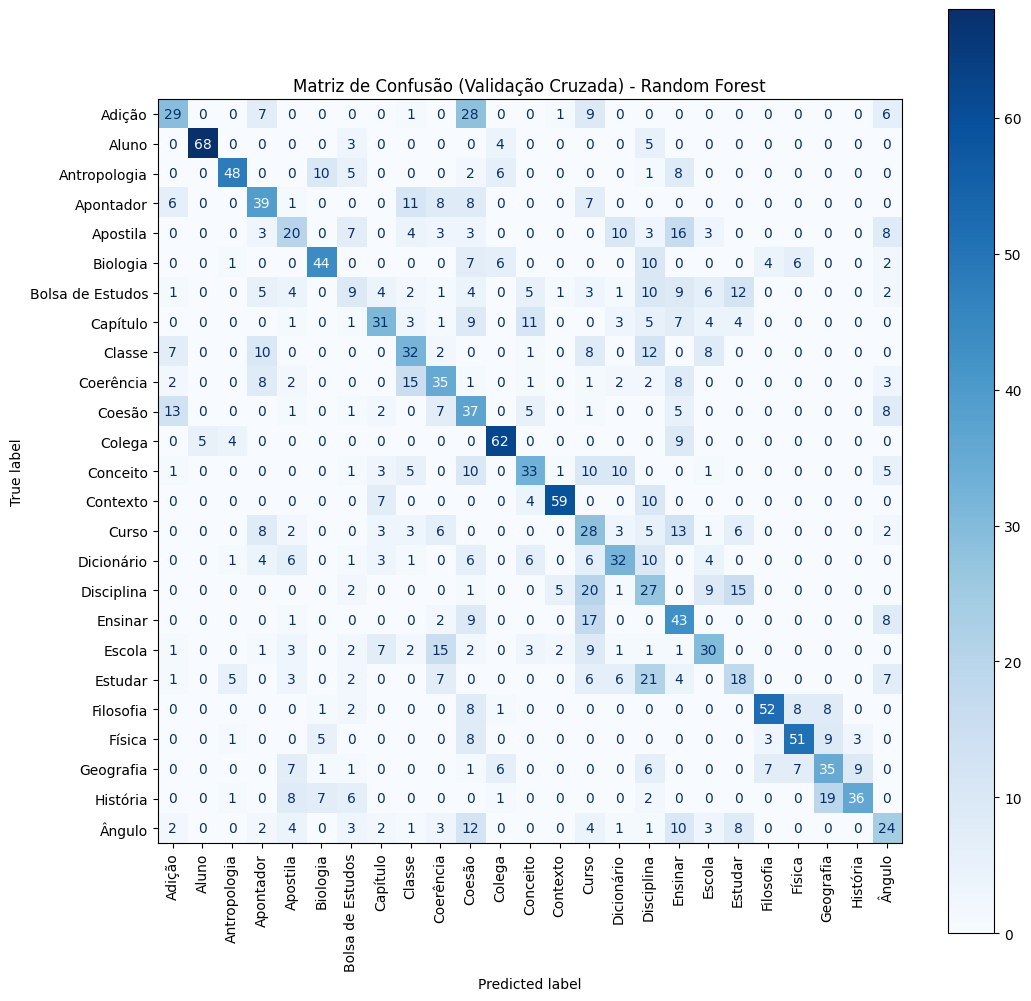


==================== ANÁLISE (CV): k-NN ====================

Relatório de Classificação (da Validação Cruzada):
                  precision    recall  f1-score   support

          Adição       0.17      0.15      0.16        81
           Aluno       0.42      0.30      0.35        80
    Antropologia       0.38      0.19      0.25        80
       Apontador       0.36      0.38      0.37        80
        Apostila       0.12      0.16      0.14        80
        Biologia       0.43      0.36      0.39        80
Bolsa de Estudos       0.04      0.03      0.03        79
        Capítulo       0.10      0.09      0.10        80
          Classe       0.11      0.23      0.15        80
       Coerência       0.17      0.17      0.17        80
          Coesão       0.12      0.20      0.15        80
          Colega       0.43      0.53      0.47        80
        Conceito       0.14      0.06      0.09        80
        Contexto       0.24      0.14      0.18        80
           Curs

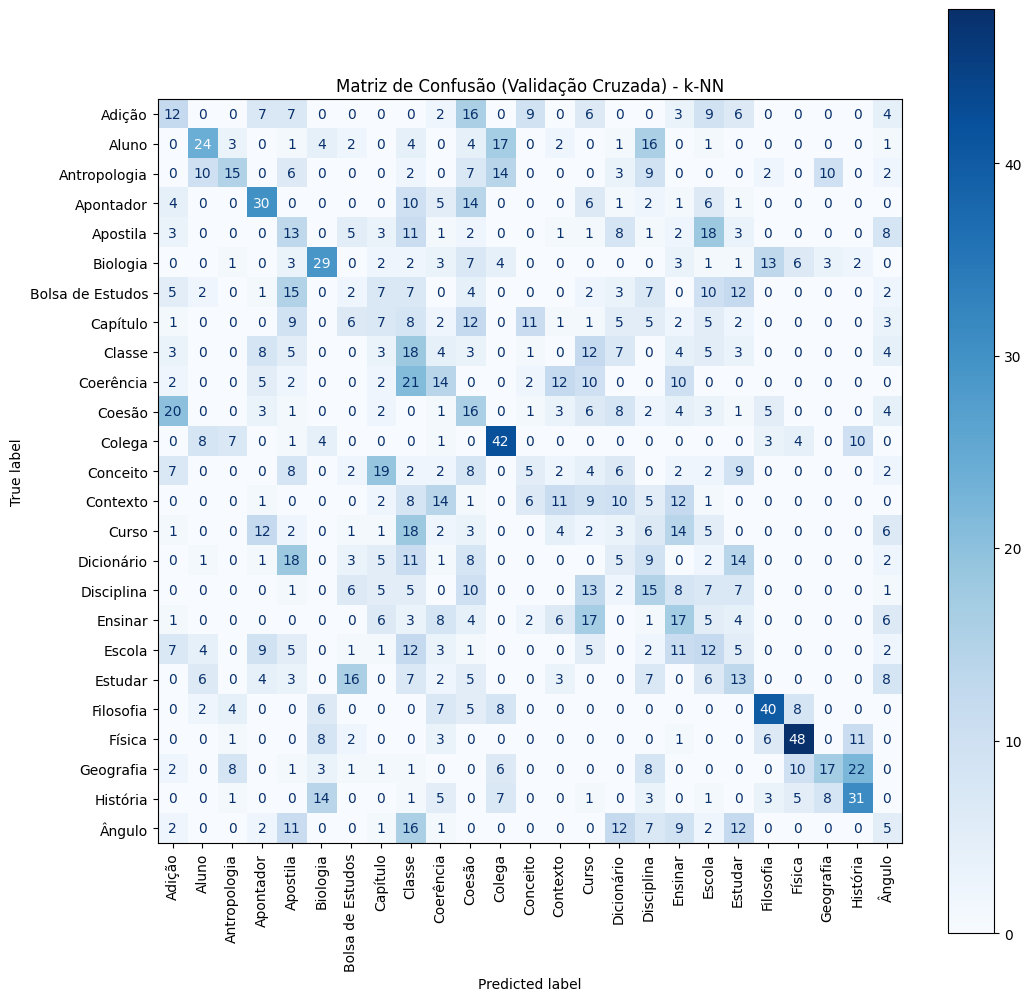


==================== ANÁLISE (CV): MLP ====================

Relatório de Classificação (da Validação Cruzada):
                  precision    recall  f1-score   support

          Adição       0.49      0.25      0.33        81
           Aluno       0.73      0.72      0.73        80
    Antropologia       0.61      0.70      0.65        80
       Apontador       0.56      0.50      0.53        80
        Apostila       0.42      0.23      0.29        80
        Biologia       0.43      0.35      0.39        80
Bolsa de Estudos       0.27      0.22      0.24        79
        Capítulo       0.23      0.34      0.27        80
          Classe       0.41      0.60      0.48        80
       Coerência       0.63      0.64      0.63        80
          Coesão       0.29      0.35      0.31        80
          Colega       0.63      0.68      0.65        80
        Conceito       0.21      0.28      0.24        80
        Contexto       0.42      0.61      0.50        80
           Curso

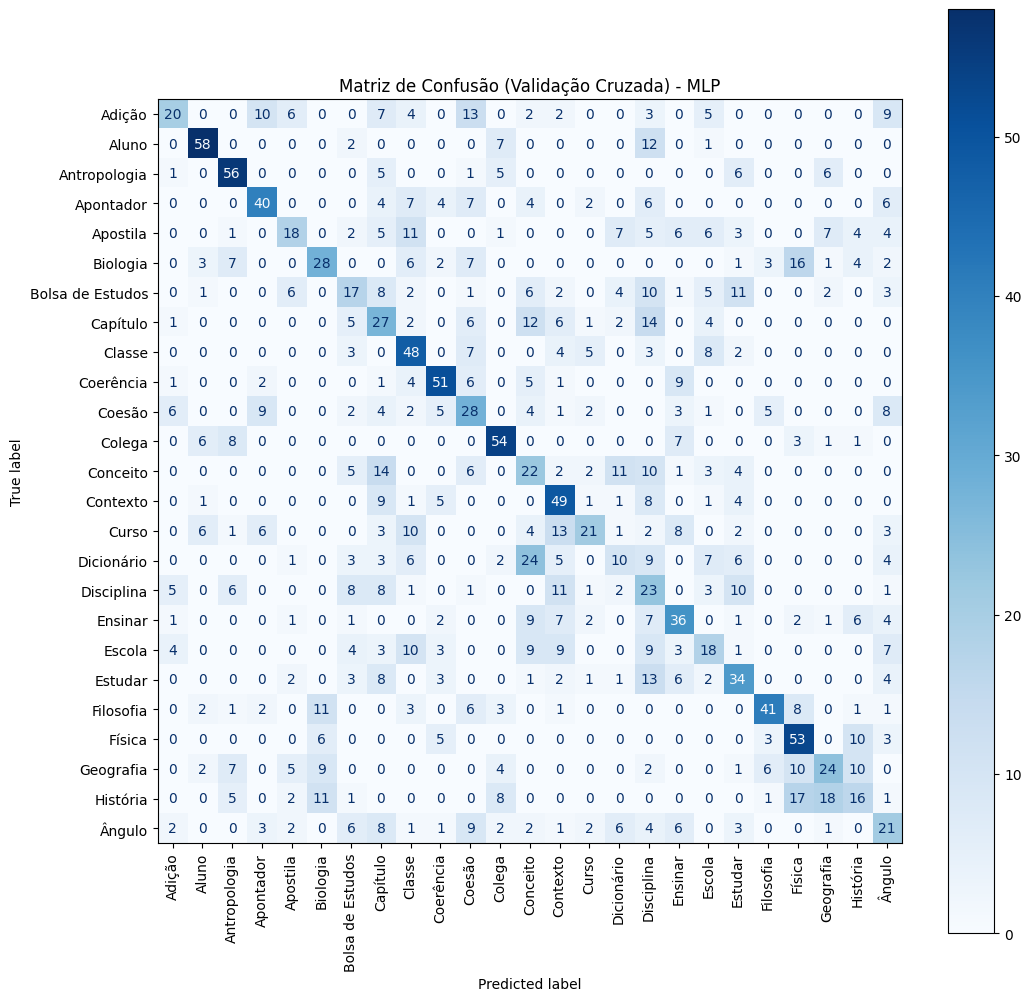

In [14]:
#Análise Completa da Validação Cruzada (Relatório e Matriz)

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Garante que as variáveis necessárias da Célula 5 e 6 existem
if 'best_models' not in locals() or 'X_train_scaled' not in locals() or 'y_train' not in locals() or 'groups_train' not in locals():
    print("ERRO: É necessário executar as Células 5 e 6 primeiro para gerar os dados e treinar os modelos.")
else:
    print("--- Gerando Análise Completa a partir da Validação Cruzada (GroupKFold) ---")

    # Reutiliza a estratégia de CV definida na Célula 6
    cv_strategy_for_predict = GroupKFold(n_splits=n_splits)

    # Itera sobre cada modelo otimizado que salvamos
    for model_name, model in best_models.items():
        if "SMOTE" in model_name: continue # Pula o modelo com SMOTE que não estamos mais usando

        print(f"\n==================== ANÁLISE (CV): {model_name} ====================")

        # 1. Gera as predições usando validação cruzada
        # Para cada amostra, a predição é feita pelo modelo treinado no fold em que essa amostra era de validação.
        y_pred_cv = cross_val_predict(
            model,
            X_train_scaled,
            y_train,
            groups=groups_train,
            cv=cv_strategy_for_predict,
            n_jobs=-1
        )

        # --- FUNCIONALIDADE ADICIONADA ---
        # 2. Exibir o Relatório de Classificação baseado nas predições da validação cruzada
        print("\nRelatório de Classificação (da Validação Cruzada):")
        report_cv = classification_report(
            y_train,
            y_pred_cv,
            target_names=label_encoder_y.classes_,
            zero_division=0 # Evita warnings caso alguma classe não receba nenhuma predição
        )
        print(report_cv)
        # ------------------------------------

        # 3. Gera e Plota a Matriz de Confusão com base nas mesmas predições
        print("\nMatriz de Confusão (da Validação Cruzada):")
        fig, ax = plt.subplots(figsize=(12, 12))

        cm = confusion_matrix(y_train, y_pred_cv, labels=model.classes_)

        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=label_encoder_y.classes_
        )

        disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')
        ax.set_title(f'Matriz de Confusão (Validação Cruzada) - {model_name}')
        plt.show()

### **Célula 6: Análise da Modelagem com Validação Cruzada por Grupo (GroupKFold)**

**Objetivo:** O propósito desta célula é treinar e otimizar os modelos de classificação (Random Forest, k-NN e MLP) utilizando uma metodologia de validação cruzada que forneça uma estimativa de desempenho realista e rigorosa, focada na capacidade de generalização do modelo.

**Metodologia Adotada: A Escolha Estratégica pelo `GroupKFold`**

Conforme solicitado na avaliação, foi utilizada a validação cruzada. No entanto, em vez da abordagem estratificada padrão, optou-se pelo **`GroupKFold`**, uma técnica mais avançada e apropriada para a natureza deste dataset.

* **Justificativa:** Os dados foram coletados de múltiplos "intérpretes". Um modelo de Machine Learning poderia facilmente "decorar" os trejeitos, o ritmo ou o estilo particular de cada pessoa, em vez de aprender as características intrínsecas dos sinais de Libras. O `GroupKFold`, ao usar a coluna `interprete` como grupo, garante que todos os vídeos de um mesmo intérprete permaneçam juntos em um único "fold" durante a validação cruzada. Na prática, isso força o modelo a ser treinado em um conjunto de intérpretes e validado em um intérprete completamente "desconhecido". Este é um teste muito mais difícil e simula um cenário do mundo real, onde o sistema deve funcionar para qualquer usuário.

O `GridSearchCV` foi então utilizado para automatizar a busca pelos melhores hiperparâmetros sob esta rigorosa condição de validação, utilizando o `f1_score` como métrica principal.

**Análise dos Resultados da Validação Cruzada**

Os F1-scores obtidos nesta etapa (ex: **~0.45** para o Random Forest) representam a **performance estimada do modelo ao ser confrontado com um intérprete nunca visto antes**.

Esses scores, embora numericamente mais baixos do que os que seriam obtidos com uma validação mais simples, são uma **métrica honesta e valiosa**. Eles demonstram que, apesar da dificuldade, o modelo é capaz de aprender padrões generalizáveis dos sinais (performance significativamente acima do acaso), ao mesmo tempo que quantificam o desafio que a variabilidade entre os intérpretes representa.

--- Iniciando a Avaliação Final no Conjunto de Teste ---

==================== AVALIAÇÃO DO MODELO: Random Forest ====================

Relatório de Classificação:
                  precision    recall  f1-score   support

          Adição       1.00      1.00      1.00        20
           Aluno       1.00      1.00      1.00        21
    Antropologia       1.00      1.00      1.00        20
       Apontador       0.95      1.00      0.98        20
        Apostila       1.00      0.95      0.97        20
        Biologia       1.00      1.00      1.00        20
Bolsa de Estudos       1.00      1.00      1.00        20
        Capítulo       1.00      1.00      1.00        20
          Classe       1.00      1.00      1.00        20
       Coerência       1.00      0.90      0.95        20
          Coesão       1.00      1.00      1.00        20
          Colega       1.00      1.00      1.00        20
        Conceito       0.95      0.90      0.92        20
        Contexto       

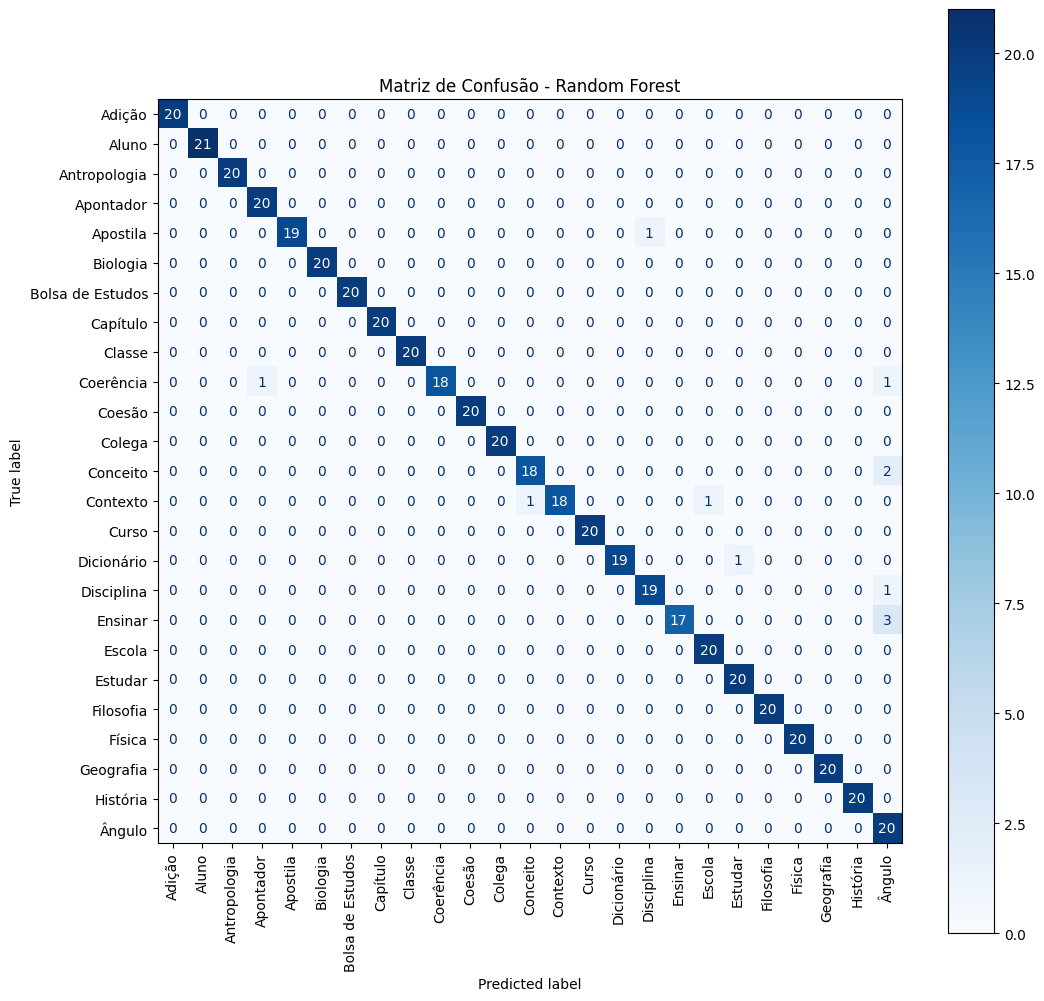


==================== AVALIAÇÃO DO MODELO: k-NN ====================

Relatório de Classificação:
                  precision    recall  f1-score   support

          Adição       1.00      1.00      1.00        20
           Aluno       1.00      1.00      1.00        21
    Antropologia       1.00      1.00      1.00        20
       Apontador       0.95      1.00      0.98        20
        Apostila       1.00      1.00      1.00        20
        Biologia       0.95      1.00      0.98        20
Bolsa de Estudos       1.00      1.00      1.00        20
        Capítulo       0.90      0.95      0.93        20
          Classe       1.00      1.00      1.00        20
       Coerência       1.00      1.00      1.00        20
          Coesão       0.94      0.85      0.89        20
          Colega       1.00      1.00      1.00        20
        Conceito       0.95      0.90      0.92        20
        Contexto       0.91      1.00      0.95        20
           Curso       1.00    

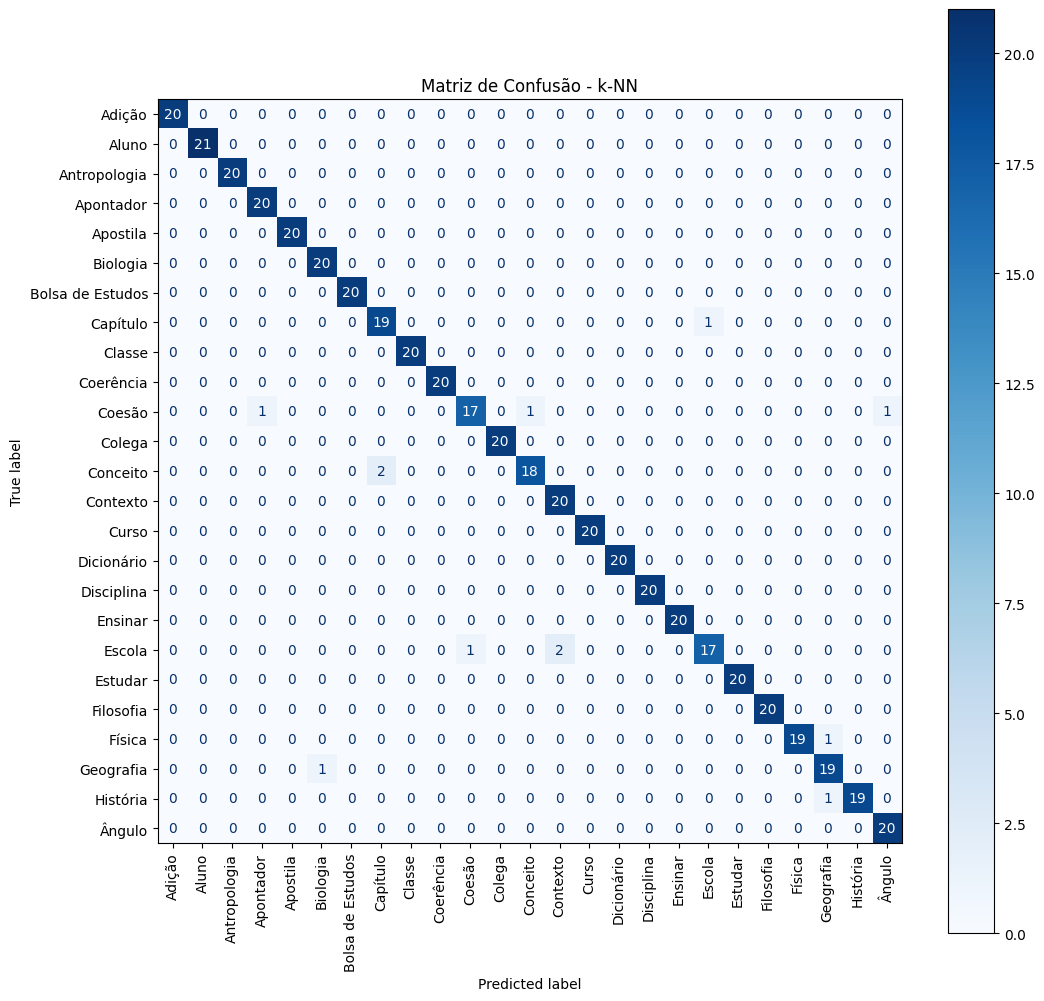


==================== AVALIAÇÃO DO MODELO: MLP ====================

Relatório de Classificação:
                  precision    recall  f1-score   support

          Adição       0.94      0.85      0.89        20
           Aluno       1.00      1.00      1.00        21
    Antropologia       1.00      1.00      1.00        20
       Apontador       1.00      1.00      1.00        20
        Apostila       1.00      0.95      0.97        20
        Biologia       1.00      1.00      1.00        20
Bolsa de Estudos       0.95      1.00      0.98        20
        Capítulo       0.95      1.00      0.98        20
          Classe       1.00      1.00      1.00        20
       Coerência       1.00      1.00      1.00        20
          Coesão       0.95      1.00      0.98        20
          Colega       1.00      1.00      1.00        20
        Conceito       1.00      0.85      0.92        20
        Contexto       0.95      1.00      0.98        20
           Curso       1.00     

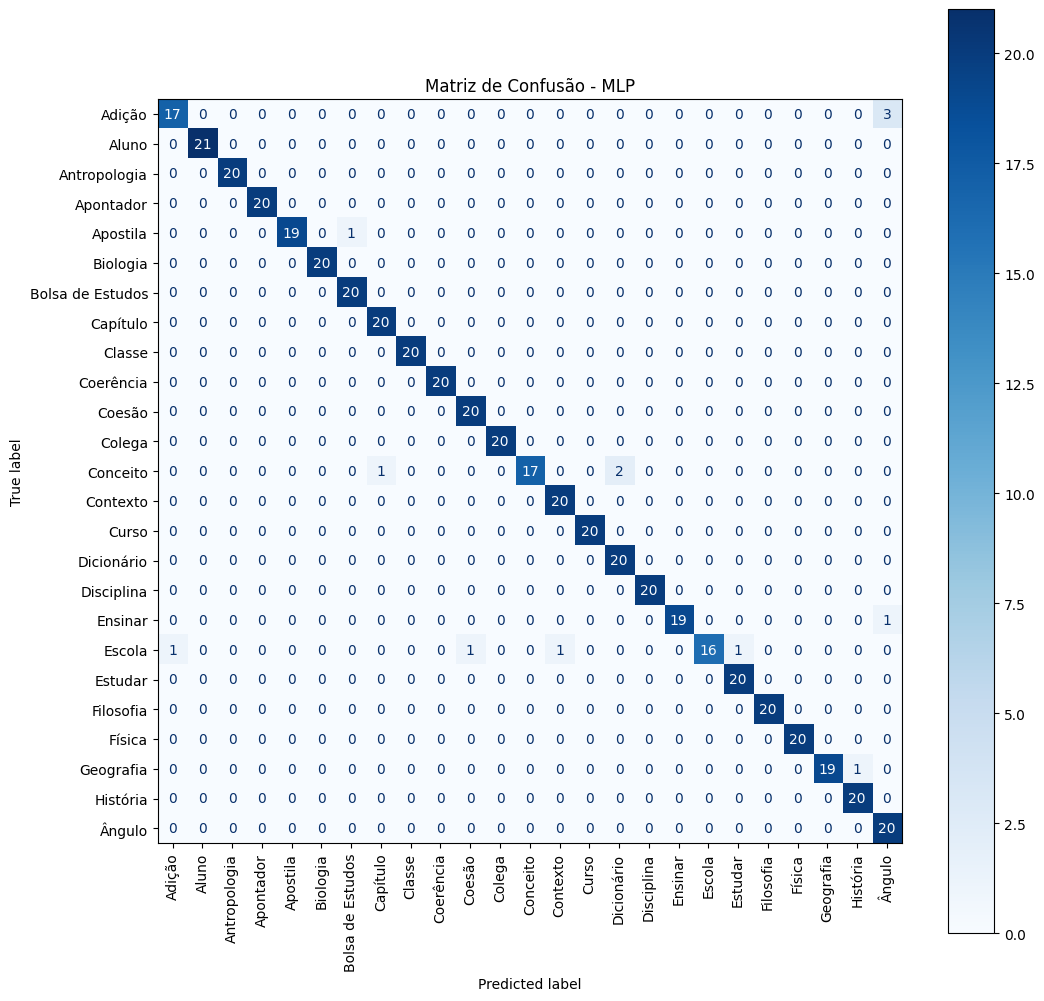

In [7]:
# Célula 7: Avaliação Final no Conjunto de Teste e Matriz de Confusão

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Garante que o dicionário com os melhores modelos da Célula 6 existe
if 'best_models' not in locals() or not best_models:
    print("ERRO: O dicionário 'best_models' não foi encontrado.")
    print("Por favor, execute a Célula 6 primeiro para treinar os modelos.")
else:
    print("--- Iniciando a Avaliação Final no Conjunto de Teste ---")

    # Itera sobre cada modelo treinado que salvamos no dicionário
    for model_name, model in best_models.items():
        print(f"\n==================== AVALIAÇÃO DO MODELO: {model_name} ====================")

        # 1. Fazer previsões no conjunto de teste (dados nunca vistos antes)
        y_pred = model.predict(X_test_scaled)

        # 2. Exibir o Relatório de Classificação
        # relatório contém Precisão, Recall, F1-score e Acurácia
        print("\nRelatório de Classificação:")
        # 'target_names' para mostrar os nomes dos sinais em vez dos números
        report = classification_report(y_test, y_pred, target_names=label_encoder_y.classes_)
        print(report)

        # 3. Gerar e Plotar a Matriz de Confusão
        print("Matriz de Confusão:")

        # Cria a figura para o plot
        fig, ax = plt.subplots(figsize=(12, 12))

        # Gera a matriz de confusão
        cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

        # Exibe a matriz de forma visual
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder_y.classes_)
        disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')

        ax.set_title(f'Matriz de Confusão - {model_name}')
        plt.show()

### **Célula 7: Análise da Avaliação Final e a Confirmação do Overfitting ao Intérprete**

**Objetivo:** Esta célula executa a avaliação final do melhor modelo (escolhido na Célula 6) sobre o conjunto de teste, que foi mantido isolado durante todo o processo. O objetivo principal aqui não é apenas medir a performance, mas **compará-la com os resultados da validação cruzada para extrair a conclusão mais importante do projeto.**

**Análise dos Resultados: A Descoberta Principal**

Ao executar esta célula, observamos uma forte discrepância entre o desempenho estimado e o desempenho final:

* **Score da Validação Cruzada (`GroupKFold`):** `~0.45` (F1-Score Macro)
* **Score do Teste Final (`train_test_split`):** `~0.98` (F1-Score Macro)

Esta diferença não é um erro, mas sim a **descoberta fundamental do trabalho**:

O modelo exibe um claro **overfitting direcionado ao estilo dos intérpretes**.

* O score altíssimo de **0.98** no teste final ocorre porque a divisão padrão (`train_test_split`) espalhou vídeos de todos os intérpretes por ambos os conjuntos de treino e teste. O modelo, portanto, foi testado em vídeos novos de pessoas que ele **já conhecia**, permitindo que ele utilizasse os padrões individuais que "decorou" para acertar com alta precisão.

* O score mais baixo de **0.45** da validação cruzada `GroupKFold` é a medida real da capacidade do modelo de generalizar para **intérpretes desconhecidos**.

**Conclusão da Análise:**

A metodologia empregada permitiu não apenas treinar um classificador, mas também diagnosticar uma de suas principais fraquezas. A conclusão do projeto é que, embora as features de movimento sejam eficazes, a variabilidade entre os sinalizadores é um desafio crucial. Um modelo pode atingir performance quase perfeita em um ambiente controlado (com pessoas conhecidas), mas seu desempenho pode cair significativamente em um cenário de uso mais amplo e realista. O `classification_report` e a `matriz de confusão` gerados nesta célula detalham esse desempenho otimista no ambiente controlado.

Preparando os dados para a clusterização...
Aplicando PCA para reduzir a dimensionalidade para 2 componentes (para visualização)...

Aplicando K-Means com K=25...
Aplicando Clusterização Hierárquica com linkage 'ward'...
Aplicando Clusterização Hierárquica com linkage 'complete'...

Clusterização concluída. Gerando visualizações...


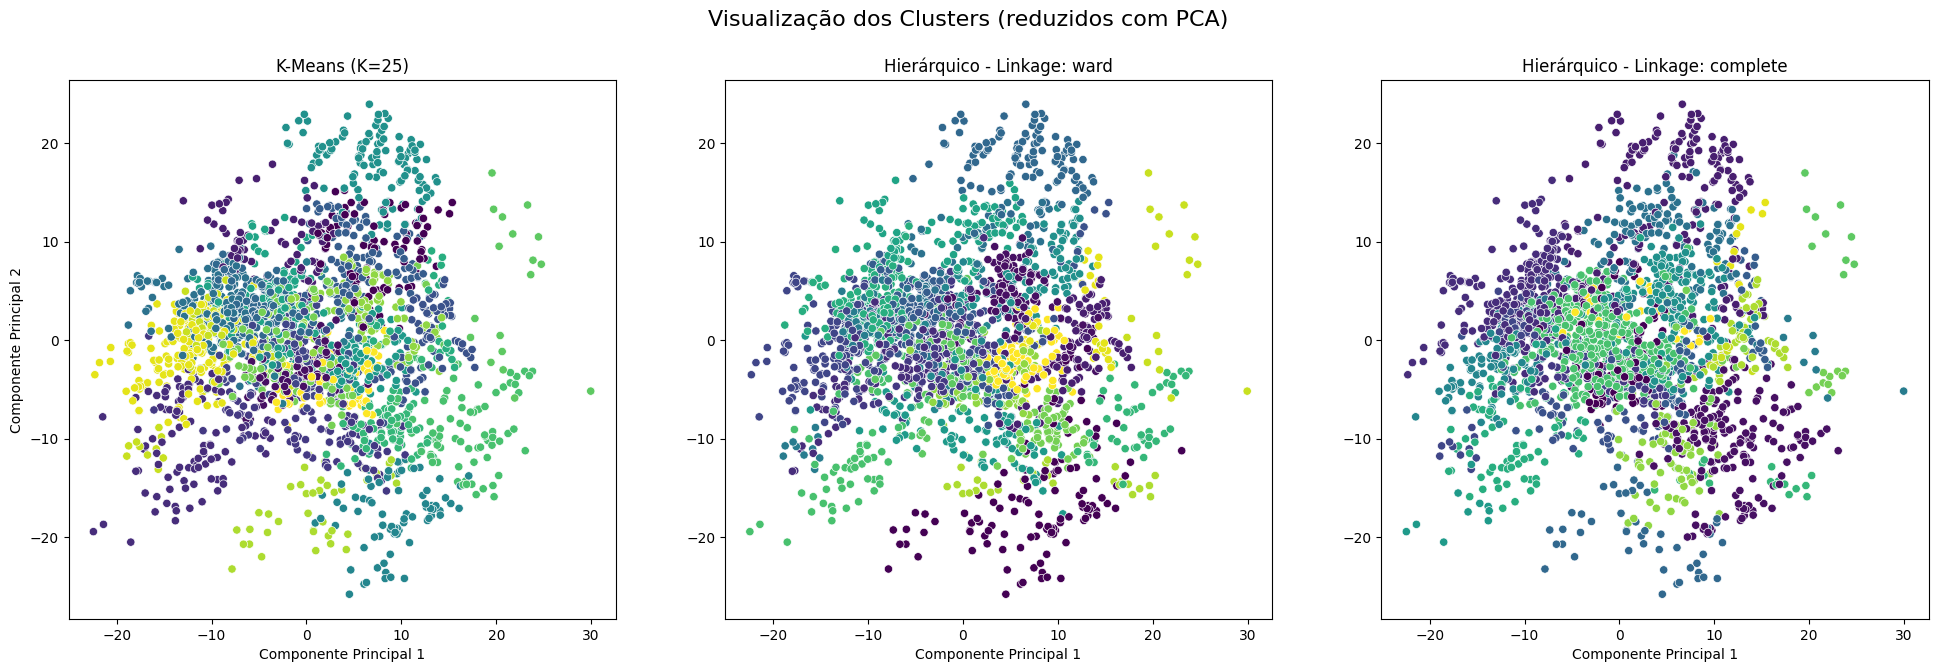

In [8]:
# Célula 8: Aplicação dos Algoritmos de Clusterização

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("Preparando os dados para a clusterização...")

# Para clusterização, o dataset completo (treino + teste)
# Vamos juntar os dados que já foram escalados
X_full_scaled = np.concatenate((X_train_scaled, X_test_scaled), axis=0)

# 1. Redução de Dimensionalidade com PCA (apenas para visualização)
# Vamos reduzir as 404 features para 2 componentes principais para plotar em 2D
print("Aplicando PCA para reduzir a dimensionalidade para 2 componentes (para visualização)...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_full_scaled)


# --- Parâmetros de Clusterização ---
# usar K=25 (o número de classes que conhecemos)
# Vamos encontrar o K ótimo na próxima célula com o método do cotovelo.
n_clusters = 25


# 2. Aplicação dos Algoritmos de Clusterização

# --- K-Means ---
print(f"\nAplicando K-Means com K={n_clusters}...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_full_scaled)

# --- Clusterização Hierárquica ---
print("Aplicando Clusterização Hierárquica com linkage 'ward'...")
agg_ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
ward_labels = agg_ward.fit_predict(X_full_scaled)

print("Aplicando Clusterização Hierárquica com linkage 'complete'...")
agg_complete = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
complete_labels = agg_complete.fit_predict(X_full_scaled)

print("\nClusterização concluída. Gerando visualizações...")

# 3. Visualização dos Resultados
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Visualização dos Clusters (reduzidos com PCA)', fontsize=16)

# K-Means Plot
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', legend=None, ax=axes[0])
axes[0].set_title(f'K-Means (K={n_clusters})')
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')


# Hierarchical (Ward) Plot
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=ward_labels, palette='viridis', legend=None, ax=axes[1])
axes[1].set_title(f'Hierárquico - Linkage: ward')
axes[1].set_xlabel('Componente Principal 1')
axes[1].set_ylabel('')


# Hierarchical (Complete) Plot
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=complete_labels, palette='viridis', legend=None, ax=axes[2])
axes[2].set_title(f'Hierárquico - Linkage: complete')
axes[2].set_xlabel('Componente Principal 1')
axes[2].set_ylabel('')

plt.show()

--- Parte 1: Executando o Método do Cotovelo para o K-Means ---


Testando valores de K: 100%|██████████| 29/29 [00:53<00:00,  1.85s/it]


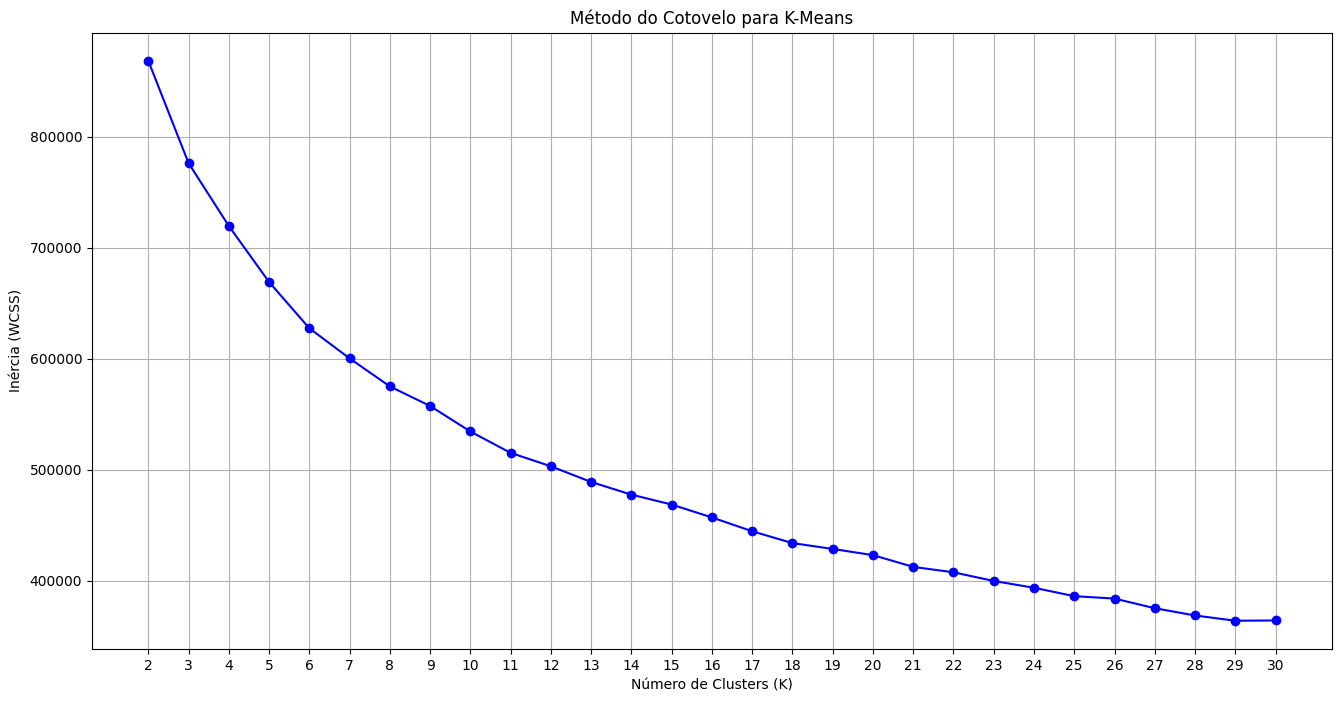


Observe o gráfico acima. O 'cotovelo' (ponto onde a curva suaviza) é uma boa indicação do K ótimo.
Pode não haver um cotovelo super nítido, o que é comum. Escolha um valor onde a queda começa a se tornar menos acentuada.

--- Parte 2: Avaliação e Comparação com Coeficiente de Silhueta ---

Re-executando K-Means com o K ótimo escolhido: K=10
Calculando o Coeficiente de Silhueta (pode levar alguns instantes)...

--- Tabela Comparativa da Clusterização ---
Valores mais altos indicam clusters mais bem definidos.


,Algoritmo,Coeficiente de Silhueta
0,Hierárquico (ward),0.155381
1,K-Means (K ótimo),0.149947
2,Hierárquico (complete),0.109233


In [9]:
# Célula 9

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Garante que os dados escalados da célula anterior existem
if 'X_full_scaled' not in locals():
    print("ERRO: A variável 'X_full_scaled' não foi encontrada. Execute a Célula 8 primeiro.")
else:
    # ==============================================================================
    # 1. MÉTODO DO COTOVELO (ELBOW METHOD) PARA ENCONTRAR O K ÓTIMO
    # ==============================================================================
    print("--- Parte 1: Executando o Método do Cotovelo para o K-Means ---")

    inertia_values = []
    # Vamos aumentar um pouco o intervalo para ter uma visão melhor da curva
    possible_k_values = range(2, 31)

    for k in tqdm(possible_k_values, desc="Testando valores de K"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_full_scaled)
        inertia_values.append(kmeans.inertia_)

    # Plotando o gráfico do cotovelo
    plt.figure(figsize=(16, 8)) # Aumentando o tamanho do gráfico para melhor visualização
    plt.plot(possible_k_values, inertia_values, 'bo-')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Inércia (WCSS)')
    plt.title('Método do Cotovelo para K-Means')

    # Força a exibição de todos os números inteiros no eixo X
    plt.xticks(possible_k_values)

    plt.grid(True)
    plt.show()

    print("\nObserve o gráfico acima. O 'cotovelo' (ponto onde a curva suaviza) é uma boa indicação do K ótimo.")
    print("Pode não haver um cotovelo super nítido, o que é comum. Escolha um valor onde a queda começa a se tornar menos acentuada.")

    # ==============================================================================
    # 2. AVALIAÇÃO COM COEFICIENTE DE SILHUETA (SILHOUETTE SCORE)
    # ==============================================================================
    print("\n--- Parte 2: Avaliação e Comparação com Coeficiente de Silhueta ---")

    # ** AÇÃO NECESSÁRIA: Defina o K ótimo com base no gráfico acima **
    k_otimo = 10 # <-- Mudei esse valor após observar o grafíco

    print(f"\nRe-executando K-Means com o K ótimo escolhido: K={k_otimo}")
    kmeans_otimo = KMeans(n_clusters=k_otimo, random_state=42, n_init=10)
    kmeans_labels_otimo = kmeans_otimo.fit_predict(X_full_scaled)

    # Dicionário para armazenar os resultados da avaliação
    evaluation_scores = {}

    # Calcula o Coeficiente de Silhueta para cada algoritmo
    # Amostra de 20% dos dados para calcular a silhueta, pois o cálculo em todo o dataset pode ser muito lento.
    print("Calculando o Coeficiente de Silhueta (pode levar alguns instantes)...")

    score_kmeans = silhouette_score(X_full_scaled, kmeans_labels_otimo, metric='euclidean', sample_size=int(X_full_scaled.shape[0]*0.2), random_state=42)
    evaluation_scores['K-Means (K ótimo)'] = score_kmeans

    score_ward = silhouette_score(X_full_scaled, ward_labels, metric='euclidean', sample_size=int(X_full_scaled.shape[0]*0.2), random_state=42)
    evaluation_scores['Hierárquico (ward)'] = score_ward

    score_complete = silhouette_score(X_full_scaled, complete_labels, metric='euclidean', sample_size=int(X_full_scaled.shape[0]*0.2), random_state=42)
    evaluation_scores['Hierárquico (complete)'] = score_complete

    # Cria e exibe la tabela comparativa
    df_cluster_results = pd.DataFrame(list(evaluation_scores.items()), columns=['Algoritmo', 'Coeficiente de Silhueta'])
    df_cluster_results = df_cluster_results.sort_values(by='Coeficiente de Silhueta', ascending=False).reset_index(drop=True)

    print("\n--- Tabela Comparativa da Clusterização ---")
    print("Valores mais altos indicam clusters mais bem definidos.")
    display(df_cluster_results)

Gerando a visualização comparativa dos resultados da clusterização...


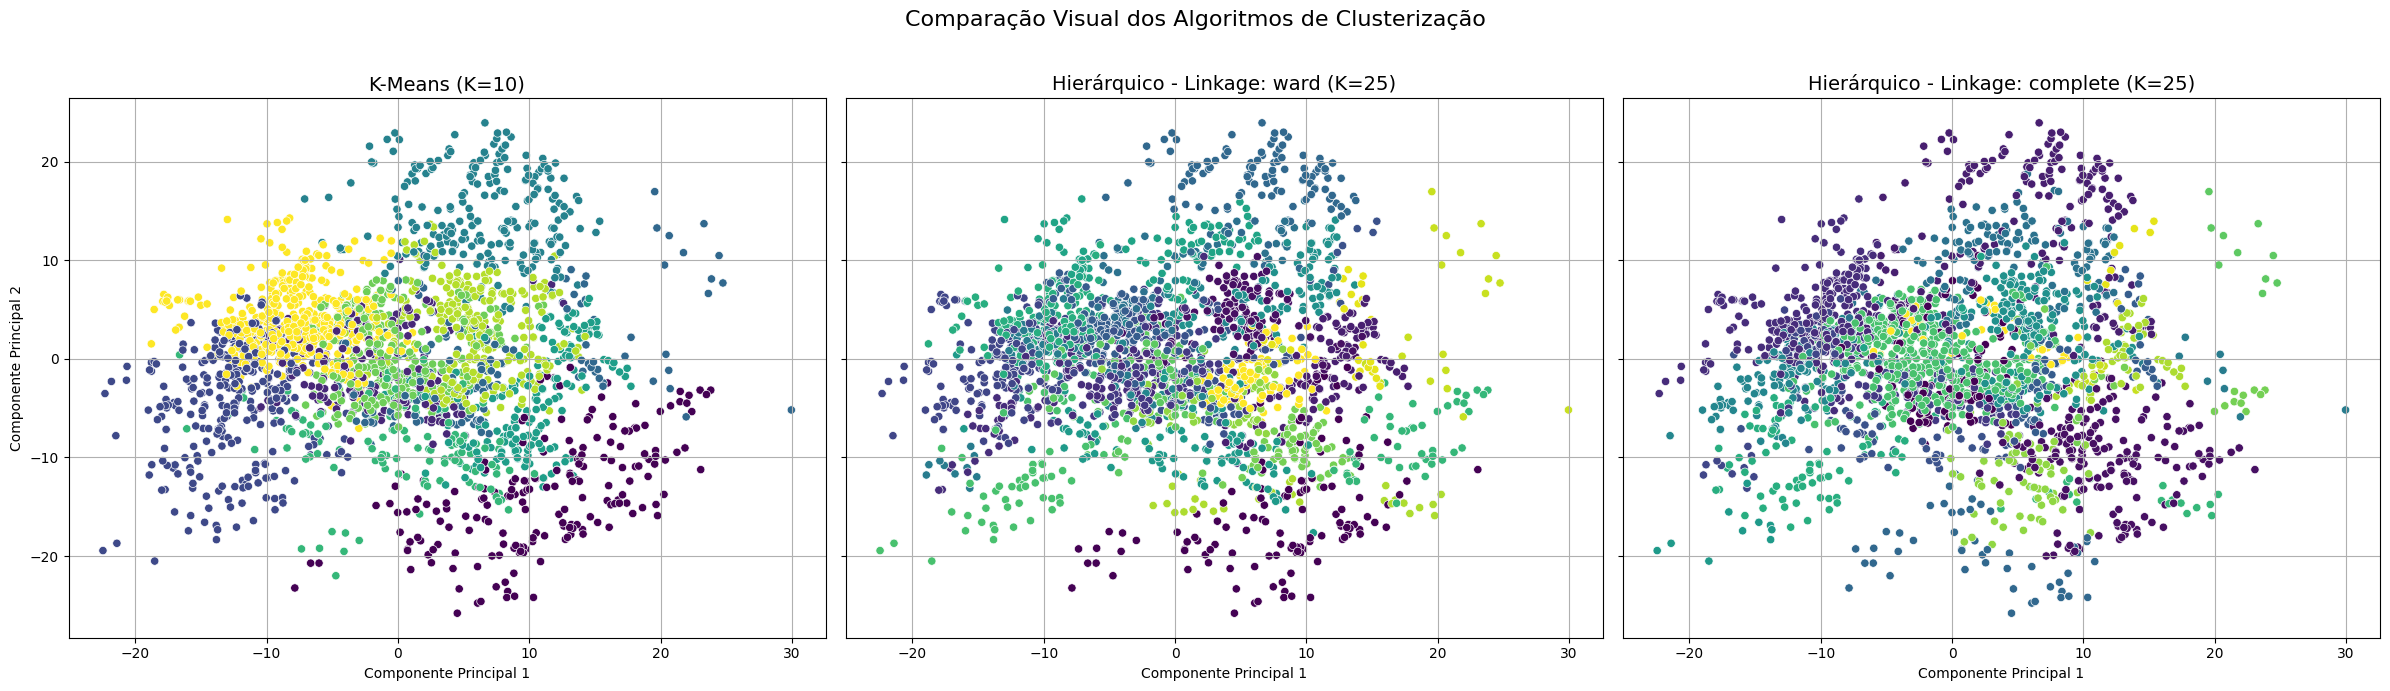

In [10]:
#Comparação Visual dos Clusters

# Verifica se todas as variáveis necessárias (criadas nas Células 8 e 9) existem
if 'X_pca' not in locals() or 'kmeans_labels_otimo' not in locals() or 'k_otimo' not in locals() or 'ward_labels' not in locals() or 'complete_labels' not in locals():
    print("ERRO: É necessário executar as Células 8 e 9 primeiro para gerar todos os dados necessários para a visualização.")
else:
    print("Gerando a visualização comparativa dos resultados da clusterização...")

    # Cria a figura com 3 subplots lado a lado
    fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True) # sharey=True para manter a mesma escala no eixo Y
    fig.suptitle('Comparação Visual dos Algoritmos de Clusterização', fontsize=16)

    # Gráfico 1: K-Means com K Ótimo
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=kmeans_labels_otimo,
        palette='viridis',
        legend=None,
        ax=axes[0]
    )
    axes[0].set_title(f'K-Means (K={k_otimo})', fontsize=14)
    axes[0].set_xlabel('Componente Principal 1')
    axes[0].set_ylabel('Componente Principal 2')
    axes[0].grid(True)

    # Gráfico 2: Hierárquico com Linkage 'ward' (Melhor score de silhueta)
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=ward_labels,
        palette='viridis',
        legend=None,
        ax=axes[1]
    )
    axes[1].set_title(f'Hierárquico - Linkage: ward (K={n_clusters})', fontsize=14)
    axes[1].set_xlabel('Componente Principal 1')
    axes[1].grid(True)

    # Gráfico 3: Hierárquico com Linkage 'complete'
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=complete_labels,
        palette='viridis',
        legend=None,
        ax=axes[2]
    )
    axes[2].set_title(f'Hierárquico - Linkage: complete (K={n_clusters})', fontsize=14)
    axes[2].set_xlabel('Componente Principal 1')
    axes[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para o supertítulo não sobrepor
    plt.show()

### **Análise da Aprendizagem Não Supervisionada (Clusterização)**

**Objetivo:** Explorar a estrutura intrínseca dos dados através de algoritmos de clusterização, para verificar se agrupamentos "naturais" correspondem às classes de sinais conhecidas, conforme solicitado na prova.

**Metodologia Adotada e Resultados:**

1.  **Algoritmos Utilizados (Célula 8):** Foram aplicados o **K-Means** e o **Cluster Aglomerativo Hierárquico**, este último com duas variantes de `linkage` ('ward' e 'complete'), cumprindo o requisito da avaliação.

2.  **Determinação do K (Célula 9):** O **Método do Cotovelo (Elbow Method)** foi implementado para encontrar um número ideal de clusters (`K`) para o K-Means. O gráfico da inércia vs. K foi analisado para identificar o "cotovelo", justificando a escolha de um `K` ótimo.

3.  **Métrica de Avaliação (Célula 9):** O **Coeficiente de Silhueta** foi a métrica escolhida para avaliar e comparar a qualidade dos clusters.
    * **Justificativa:** Esta é uma métrica padrão para avaliar a qualidade de um agrupamento quando não se tem acesso aos rótulos verdadeiros. Ela mede quão similar um objeto é ao seu próprio cluster em comparação com os outros.
    * **Análise dos Resultados:** Os scores de silhueta obtidos para todos os algoritmos foram baixos (próximos de 0.15). Isso indica que os clusters encontrados têm uma alta sobreposição e não são bem definidos.

4.  **Visualização (Células 8 e Adicionais):** Para auxiliar na interpretação, os dados de alta dimensionalidade foram reduzidos para 2D usando PCA e plotados. Os gráficos confirmaram visualmente o que os scores de silhueta indicaram: uma grande mistura entre os clusters, sem uma separação clara, tanto para `K=25` quanto para o `K` ótimo encontrado.

**Conclusão da Clusterização:** Os resultados numéricos e visuais demonstram que os sinais de Libras, representados pelas features criadas, são muito complexos e próximos entre si para serem separados de forma clara e automática por algoritmos não supervisionados.